**Lab-05: K-mean Clustering**

1. Randomly assign a number, from 1 to K, to each observations. There serve as initial cluster assignments for the observations.
2. Iterate until the cluster assignments stop changing:
    
    2.1 For each of the K clusters, compute the cluster centroid. the $k_th$ cluster centroid is the vector of the "p" feature means for the observations in the "kth" cluster.
    
    2.2 Assign each observation to the cluster whose centroid is closest (where closest is defined using Euclidean distance).



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist,euclidean
from numpy.linalg import norm

#Bài tập

1. Hãy dùng thuật toán K-mean để chọn ra số cụm thích hợp (như trong slide bài giảng) dựa trên tập training, và dự đoán label của các quan sát trên tập testing của bộ dữ liệu bên dưới.
2. Vẽ hình các cụm trên tập testing

Đường cong WCV nên như sau:

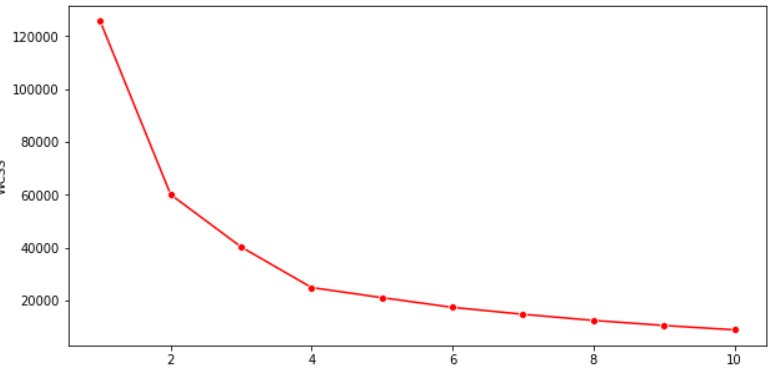

In [2]:
!wget "https://raw.githubusercontent.com/huynhthanh98/ML/master/lab-05/data.csv"

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
data=pd.read_csv("data.csv")
data.head()


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Đây là data thông tin về khách hàng. Từ đây, ta sẽ tiến hành phân cụm các khách hàng này.
data này gồm:
* CustomerID: Số thứ tự khách hàng
* Genre: Giới tính
* Age: Tuổi
* Annual Income: Mức thu nhập hằng năm
* Spending Score: Chỉ số tiêu dùng 

In [4]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
#Check data có NULL hay không
data.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
#Drop duplicates 
data.drop_duplicates(inplace=True)

In [7]:
X = data.iloc[:, [2, 3]].values
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)

In [8]:
print(X_train.shape)
print(X_test.shape)

(134, 2)
(66, 2)


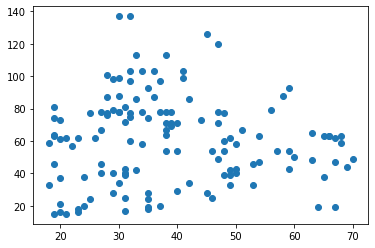

In [9]:
plt.scatter(X_train[:,0], X_train[:,1])

In [10]:
#Vẽ hình thử
def kmeans_display(X, label, centroids):
    l = plt.scatter(X[:,0], X[:,1], c = label, cmap='viridis', s = 50, alpha = .8)
    c = plt.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 55, color = 'r', label = "Centroids")
    plt.legend(*l.legend_elements())
    plt.plot()
    plt.show()

## Model Kmeans

In [11]:
class Kmeans:
    def __init__(self, n_clusters, max_iter = 100, random_state=None):
        """
        Parameter:
            n_clusters: int, default=8
                The number of clusters to form as well as the number of centroids to generate.
                    
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a single run.
                
            random_state; int, RandomState instance or None, default=None
                Determines random number generation for centroid initialization. 
                Use an int to make the randomness deterministic
         Returns
            -------
            centroids : ndarray of shape (n_clusters, n_features)
                Centroids found at the last iteration of k-means.
                
            labels : ndarray of shape (n_samples,)
                label[i] is the code or index of the centroid the
                i'th observation is closest to.
                
            inertia : float
                The final value of the inertia criterion (sum of squared distances to
                the closest centroid for all observations in the training set).
                
            n_iter : int
                Number of iterations run
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        
    def _init_centroid(self,X):
        # randomly pick n_clusters rows of X as initial centers
        random_St = np.random.RandomState(self.random_state)
        random_idx = random_St.permutation(X.shape[0])
        return X[random_idx[:self.n_clusters]]

    def _compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0],self.n_clusters))
        # calculate pairwise distances btw data and centers
        for k in range(self.n_clusters):
            row_norm = norm(X - centroids[k, :], axis = 1)
            distance[:,k] = np.square(row_norm)
        return distance/self.n_clusters

    def find_closest_centroid(self, distance):
        # return index of the closest center
        return np.argmin(distance, axis = 1)

    def _update_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            # collect all points assigned to the k-th cluster 
            Xk = X[labels == k, :]
            # take average
            centroids[k,:] = np.mean(Xk, axis = 0)
        return centroids

    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = norm(X[labels == k] - centroids[k], axis = 1)
        return np.sum(np.square(distance))
        

    def fit(self, X):
        self.centroids = self._init_centroid(X)
        it = 0 
        while it < self.max_iter:
            old_centroids = self.centroids
            distance = self._compute_distance(X, old_centroids)
            # Assign labels based on closest centroid
            self.labels = self.find_closest_centroid(distance)
            # Find new centroid from means of points
            self.centroids = self._update_centroids(X, self.labels)
            # check two sets of centers are the same
            if (old_centroids == self.centroids).all():
                self.n_iter = it
                break
            it += 1
        self.inertia_ = self.compute_sse(X, self.labels, self.centroids)

    def predict(self,X):
        distance = self._compute_distance(X,self.centroids)
        return self.find_closest_centroid(distance)


#### 1. Hãy dùng thuật toán K-mean để chọn ra số cụm thích hợp (như trong slide bài giảng) dựa trên tập training, và dự đoán label của các quan sát trên tập testing của bộ dữ liệu bên dưới.

In [12]:
sse = []
for k in range(2, 11):
    kmean = Kmeans(n_clusters=k ,random_state=42)
    kmean.fit(X_train)
    sse.append(kmean.inertia_)
    print('complete with ',k, 'cluster', 'in',kmean.n_iter, 'iter')

complete with  2 cluster in 8 iter
complete with  3 cluster in 2 iter
complete with  4 cluster in 4 iter
complete with  5 cluster in 4 iter
complete with  6 cluster in 5 iter
complete with  7 cluster in 6 iter
complete with  8 cluster in 6 iter
complete with  9 cluster in 9 iter
complete with  10 cluster in 9 iter


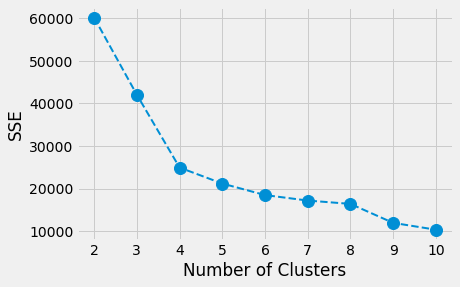

In [13]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sse, marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [14]:
kmean = Kmeans(n_clusters=4, max_iter=10 ,random_state=42)
kmean.fit(X_train)
print(kmean.n_iter)
print(kmean.centroids)
y_pred = kmean.predict(X_test)

4
[[ 37.73684211 106.47368421]
 [ 31.91304348  73.08695652]
 [ 29.25        28.6875    ]
 [ 56.45945946  49.72972973]]


In [15]:
print("SSE: ",kmean.inertia_)

SSE:  24957.086886944147


In [16]:
y_pred

array([1, 2, 3, 1, 3, 1, 2, 1, 0, 2, 3, 0, 1, 1, 0, 1, 3, 1, 3, 2, 1, 2,
       1, 1, 2, 3, 1, 3, 1, 1, 2, 2, 3, 1, 1, 3, 1, 1, 1, 3, 3, 0, 2, 3,
       1, 0, 2, 2, 1, 3, 1, 1, 2, 1, 3, 3, 1, 3, 1, 3, 1, 1, 2, 3, 2, 3],
      dtype=int64)

#### 2. Vẽ hình các cụm trên tập testing

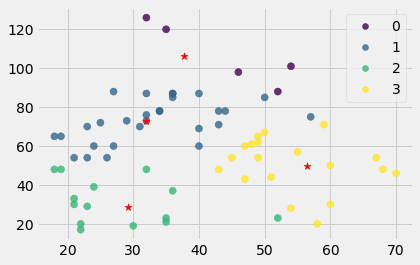

In [17]:
kmeans_display(X_test, y_pred, kmean.centroids)

## Sklearn

8
Centers found by scikit-learn:
[[ 31.91304348  73.08695652]
 [ 29.25        28.6875    ]
 [ 56.45945946  49.72972973]
 [ 37.73684211 106.47368421]]


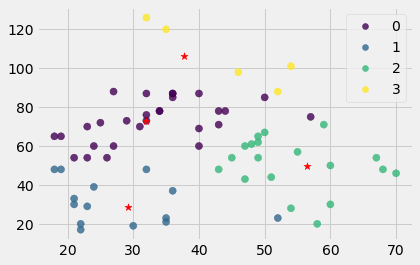

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(init='random',n_clusters=4, random_state=42, n_init=10, max_iter=100).fit(X_train)
print(kmeans.n_iter_)
print('Centers found by scikit-learn:')
print(kmeans.cluster_centers_)
pred_label = kmeans.predict(X_test)
kmeans_display(X_test, pred_label,kmeans.cluster_centers_)

In [19]:
print('SSE: ',kmeans.inertia_)

SSE:  24957.086886944155


In [20]:
sse = []
for k in range(2, 11):
    kmeans = KMeans(init='random',n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    sse.append(kmeans.inertia_)
    print('complete with ',k,'cluster in', kmeans.n_iter_, "iter")

complete with  2 cluster in 6 iter
complete with  3 cluster in 11 iter
complete with  4 cluster in 8 iter
complete with  5 cluster in 6 iter
complete with  6 cluster in 8 iter
complete with  7 cluster in 12 iter
complete with  8 cluster in 8 iter
complete with  9 cluster in 10 iter
complete with  10 cluster in 12 iter


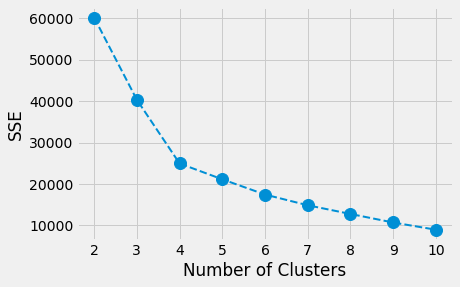

In [21]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sse, marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()